- ANTHONY SIAMPIRINGUE​
- IBRAHIM SOBH​
- ISAAC GONZALES​
- PATRICK SAADE​

In [89]:
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes

tfd = tfp.distributions

# Loding Dataset

In [131]:
# Loading diabetes dataset directly from sklearn.datasets
X, y = load_diabetes(return_X_y=True, as_frame=True)
diabetes = pd.concat((X, y), axis=1)

# Shuffle the diabetes dataset
diabetes = diabetes.sample(frac=1)

# X, y separation (for simplicity sake we only study one feature)
X = diabetes["bmi"].to_numpy().reshape(-1, 1)
y = diabetes["target"].to_numpy()

# Split the data
n = 200
X_train = X[:-n]
X_test = X[-n:]

# Split the targets
y_train = y[:-n]
y_test = y[-n:]



In [91]:
#negative log-likelihood
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

# Not Uncertainty

In [92]:
# create model with normal distribution
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
])

In [93]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=negloglik)
model.fit(X_train, y_train, epochs=2000, verbose=False)

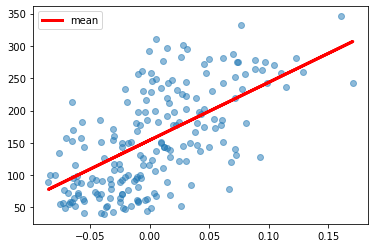

In [95]:
yhat_test = model(X_test)

plt.scatter(X_test, y_test, alpha=0.5);
plt.plot(X_test, yhat_test.mean(),'r', label='mean', linewidth=3);
plt.legend();

# Aleatoric Uncertainty

In [103]:
# create model to learn the 2 parameters of the normal distribution
# paramenters to learn: loc, mean, and scale, standard deviation. 
# because the standard deviation cannot be negative we use the softplus function
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1 + 1),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:])))
])


In [104]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=negloglik)
model.fit(X_train, y_train, epochs=2000, verbose=False);

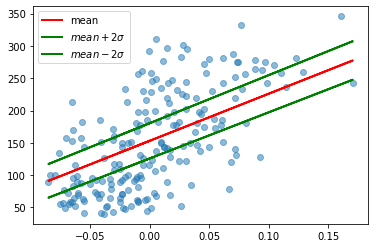

In [107]:
yhat_test = model(X_test)

plt.scatter(X_test, y_test, alpha=0.5);

m = yhat_test.mean()
s = yhat_test.stddev()

plt.plot(X_test, m, 'r', linewidth=2, label='mean');
plt.plot(X_test, m + 2 * s, 'g', linewidth=2, label=r'$mean + 2 \sigma$');
plt.plot(X_test, m - 2 * s, 'g', linewidth=2, label=r'$mean - 2 \sigma$');

plt.legend();

# Epistemic Uncertainty

In [108]:
# posterior
def posterior(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
  
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                        scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1))
  ])

In [109]:
# prior
def prior(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1))
  ])

In [110]:
# create model
# DenseVariational layer fits the weights posterior
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, 
                              posterior, 
                              prior, 
                              kl_weight=1/X.shape[0]),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
])


In [111]:
# inference
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=negloglik)
model.fit(X_train, y_train, epochs=2000, verbose=False);

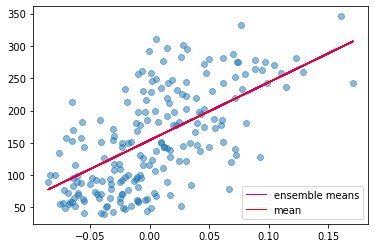

In [112]:
plt.scatter(X_test, y_test, alpha=0.5);
yhat_test_ = [model(X_test) for _ in range(200)]
avgm = np.zeros_like(X_test[..., 0])

for i, yhat in enumerate(yhat_test_):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
  
    plt.plot(X_test, m, 'm', label='ensemble means' if i == 0 else None, linewidth=1);
    avgm += m

plt.plot(X_test, avgm/len(yhat_test_), 'r', label='mean', linewidth=1);

plt.legend();

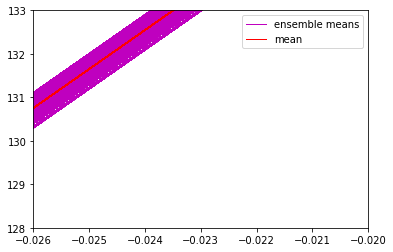

In [113]:
avgm = np.zeros_like(X_test[..., 0])

for i, yhat in enumerate(yhat_test_):
    m = np.squeeze(yhat.mean())
    plt.plot(X_test, m, 'm', label='ensemble means' if i == 0 else None, linewidth=1)
    avgm += m

plt.plot(X_test, avgm/len(yhat_test_), 'r', label='mean', linewidth=1);

plt.ylim(128,133);
plt.xlim(-0.026, -0.02);

plt.legend();

# Aleatoric & Epistemic Uncertainty

In [114]:
# create model that fits the weights posterior and the model posterior
model = tf.keras.Sequential([
    tfp.layers.DenseVariational(2, 
                              posterior, 
                              prior, 
                              kl_weight=1/X.shape[0]),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])))
])


In [115]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=negloglik)
model.fit(X_train, y_train, epochs=2000, verbose=False);

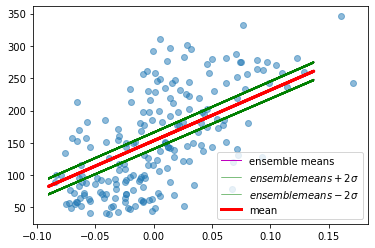

In [118]:
plt.scatter(X_test, y_test, alpha=0.5);

yhats = [model(X_train) for _ in range(200)]
avgm = np.zeros_like(X_train[..., 0])

for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())

    plt.plot(X_train, m, 'm', label='ensemble means' if i == 0 else None, linewidth=1.)
    plt.plot(X_train, m + 2 * s, 'g', linewidth=0.5, label='$ensemble means + 2 \sigma$' if i == 0 else None);
    plt.plot(X_train, m - 2 * s, 'g', linewidth=0.5, label='$ensemble means - 2 \sigma$' if i == 0 else None);
    avgm += m

plt.plot(X_train, avgm/len(yhats), 'r', label='mean', linewidth=3);
plt.legend();


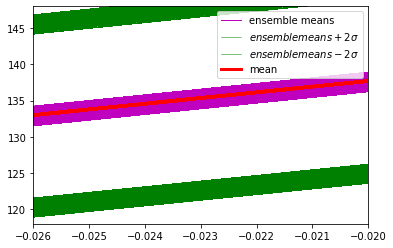

In [119]:
avgm = np.zeros_like(X_train[..., 0])

for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())

    plt.plot(X_train, m, 'm', label='ensemble means' if i == 0 else None, linewidth=1.)
    plt.plot(X_train, m + 2 * s, 'g', linewidth=0.5, label='$ensemble means + 2 \sigma$' if i == 0 else None);
    plt.plot(X_train, m - 2 * s, 'g', linewidth=0.5, label='$ensemble means - 2 \sigma$' if i == 0 else None);
    avgm += m

plt.ylim(118,148);
plt.xlim(-0.026, -0.02);
plt.plot(X_train, avgm/len(yhats), 'r', label='mean', linewidth=3);
plt.legend();

# Nonlinear Probabilistic Regression

In [139]:
X_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(X_train, 3) + 0.1 * (2 + X_train) * np.random.randn(1000)[:, np.newaxis]

In [140]:
# create model that fits the weights posterior and the model posterior 
# with activation layer sigmoid to add not linearity
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(units=2,
                              make_posterior_fn=posterior, 
                              make_prior_fn=prior, 
                              kl_weight=1/X.shape[0],
                              activation='sigmoid'),


  tfp.layers.DenseVariational(units=2,
                              make_posterior_fn=posterior, 
                              make_prior_fn=prior, 
                              kl_weight=1/X.shape[0],
                              ),
    
   tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),

])


In [141]:
model.compile(loss=negloglik, optimizer=tf.optimizers.Adam(learning_rate=0.1))

In [144]:
model.fit(X_train, y_train, epochs=2000, verbose=False)
model.evaluate(X_train, y_train)

32/32 [==============================] - 1s 3ms/step - loss: -0.1172


-0.11719513684511185

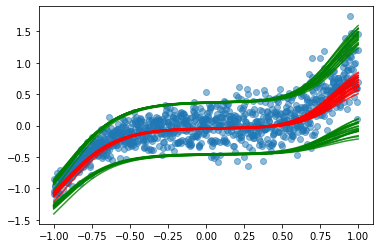

In [145]:
plt.scatter(X_train, y_train, alpha=0.5)

for i in range(20):
    y_model = model(X_train)
    y_hat = y_model.mean()

    plt.plot(X_train, y_hat, color='red', alpha=0.8, 
             label='model $\mu$' if i == 0 else None)
    plt.plot(X_train, y_hat - 2 * y_model.stddev(), color='green', 
             alpha=0.8, label='model $\mu \pm 2 \sigma$' if i == 0 else None)
    plt.plot(X_train, y_hat + 2 * y_model.stddev(), color='green', alpha=0.8)

plt.show()